In [1]:
import torch
import pandas as pd
import os
main_dir = '../wind-profiles'
#directories = ['CR1992', 'CR2056', 'CR2071', 'CR2125', 'CR2210']
directories = []
total_size = 640
segment_to_skip = 100

# three dimensional tensors, with shape (len(dir), 640, 9) and (len(dir), 640, 3)
X_data = torch.empty(0, total_size - segment_to_skip, 4)
y_data = torch.empty(0, total_size - segment_to_skip, 3)

for directory in directories:
    for file_ in os.listdir(f'{main_dir}/{directory}'):
        data = pd.read_csv(f'{main_dir}/{directory}/{file_}', delimiter=',', 
                        header=0, names=['R', 'L', 'Lon', 'Lat', 'n', 'v', 'T', 'B', 'A/A0', 'alpha', 'V/Cs', 'propag_dt'], 
                        skiprows=2, dtype=float, na_values=['                      NaN', '                     -NaN'])
        
        # if data has NaN values in R column, continue to next file
        if data[['R', 'B', 'alpha', 'n', 'v', 'T']].isnull().values.any():
            continue
        
        # convert to tensor, with shape (len(data), 3), where the three channels are R, B, alpha
        X_sample = torch.tensor(data[['R', 'L', 'B', 'alpha']].values, dtype=torch.float32)
        y_sample = torch.tensor(data[['n', 'v', 'T']].values, dtype=torch.float32)
        
        X_data = torch.cat((X_data, X_sample[segment_to_skip:, :].unsqueeze(0)), dim=0)
        y_data = torch.cat((y_data, y_sample[segment_to_skip:, :].unsqueeze(0)), dim=0)

In [7]:
# save tensors to file
# swap last two dimensions
#X_data = X_data.permute(0, 2, 1)
#y_data = y_data.permute(0, 2, 1)
#torch.save(X_data, 'X_data.pt')
#torch.save(y_data, 'y_data.pt')

In [2]:
# load tensors from file
X_data = torch.load('X_data.pt')
y_data = torch.load('y_data.pt')

In [3]:
X_data.shape, y_data.shape

(torch.Size([12939, 4, 540]), torch.Size([12939, 3, 540]))

In [4]:
# train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [5]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([9315, 4, 540]),
 torch.Size([2588, 4, 540]),
 torch.Size([9315, 3, 540]),
 torch.Size([2588, 3, 540]))

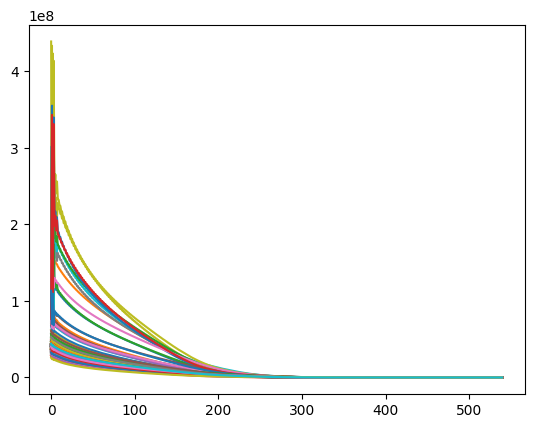

In [6]:
# plot the y_train first channel
import matplotlib.pyplot as plt
plt.plot(y_train[:200, 0, :].T)
plt.show()

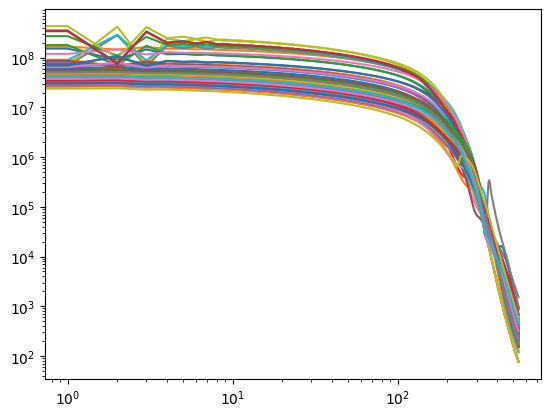

In [7]:
plt.loglog(y_train[:200, 0, :].T)
plt.show()

In [8]:
# logscale the y_train and y_val first channel
y_train[:, 0, :] = torch.log(y_train[:, 0, :])
y_val[:, 0, :] = torch.log(y_val[:, 0, :])
y_test[:, 0, :] = torch.log(y_test[:, 0, :])

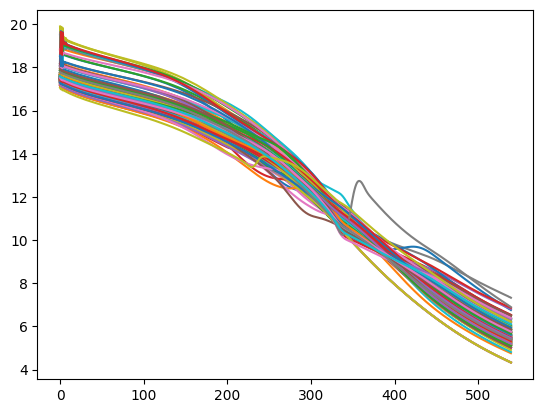

In [9]:
plt.plot(y_train[:200, 0, :].T)
plt.show()

In [10]:
# normalize data according to the maximum and minimum value in each channel
# knowing that x_train has shape (len, channels, time)

# find max and min values for each channel
max_values = X_train.max(dim=2).values.max(dim=0).values
min_values = X_train.min(dim=2).values.min(dim=0).values

diff = max_values - min_values
# if diff is zero, then the channel is constant, so we should not normalize it
diff[diff == 0] = 1

# normalize
X_train_normalized = (X_train - min_values.unsqueeze(1)) / diff.unsqueeze(1)
X_val_normalized = (X_val - min_values.unsqueeze(1)) / diff.unsqueeze(1)
X_test_normalized = (X_test - min_values.unsqueeze(1)) / diff.unsqueeze(1)

In [11]:
# normalize y data
max_values = y_train.max(dim=2).values.max(dim=0).values
min_values = y_train.min(dim=2).values.min(dim=0).values

diff = max_values - min_values

diff[diff == 0] = 1

y_train_normalized = (y_train - min_values.unsqueeze(1)) / diff.unsqueeze(1)
y_val_normalized = (y_val - min_values.unsqueeze(1)) / diff.unsqueeze(1)
y_test_normalized = (y_test - min_values.unsqueeze(1)) / diff.unsqueeze(1)

In [12]:
import torch.nn as nn
import torch.optim as optim

# Model parameters
sequence_length = total_size - segment_to_skip
input_channels = 4
output_channels = 3
batch_size = 32

In [13]:
# create me a simple 1D convolutional network
import lightning as L

class SimpleCNN(nn.Module):
    def __init__(self, input_channels, output_channels):
        super(SimpleCNN, self).__init__()
        self.input_channels = input_channels
        self.output_channels = output_channels
        self.relu = nn.ReLU()
        
        self.c1 = nn.Conv1d(input_channels, 32, kernel_size=3, stride=1)
        self.maxpool1 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.c2 = nn.Conv1d(32, 64, kernel_size=3, stride=1)
        self.maxpool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.c3 = nn.Conv1d(64, 128, kernel_size=3, stride=1)
        self.maxpool3 = nn.MaxPool1d(kernel_size=2, stride=2)
        
        self.fc1 = nn.Linear(128 * 65, 2056)
        self.batchnorm1 = nn.BatchNorm1d(2056)
        self.fc2 = nn.Linear(2056, 2056)
        self.batchnorm2 = nn.BatchNorm1d(2056)
        self.fc3 = nn.Linear(2056, output_channels * sequence_length)
        
        # Do xavier initialization
        layers = [self.fc1, self.fc2, self.fc3, self.c1, self.c2, self.c3]
        for layer in layers:
            nn.init.xavier_uniform_(layer.weight)
            nn.init.zeros_(layer.bias)
            
    def forward(self, x):
        batch_size = x.size(0)
        
        x = self.relu(self.c1(x))
        x = self.maxpool1(x)
        x = self.relu(self.c2(x))
        x = self.maxpool2(x)
        x = self.relu(self.c3(x))
        x = self.maxpool3(x)
        
        x = x.reshape(batch_size, -1)
        
        x = self.relu(self.batchnorm1(self.fc1(x)))
        x = self.relu(self.batchnorm2(self.fc2(x)))
        x = self.fc3(x)
        
        return x.reshape(batch_size, self.output_channels, sequence_length)

# Create an instance of the SimpleConvNet
model = SimpleCNN(input_channels, output_channels)

# visualize the model
from torchinfo import summary
summary(model, (batch_size, input_channels, sequence_length))

c:\Users\nrtc\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\utils\generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
c:\Users\nrtc\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\utils\generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
c:\Users\nrtc\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\utils\generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


Layer (type:depth-idx)                   Output Shape              Param #
SimpleCNN                                [32, 3, 540]              --
├─Conv1d: 1-1                            [32, 32, 538]             416
├─ReLU: 1-2                              [32, 32, 538]             --
├─MaxPool1d: 1-3                         [32, 32, 269]             --
├─Conv1d: 1-4                            [32, 64, 267]             6,208
├─ReLU: 1-5                              [32, 64, 267]             --
├─MaxPool1d: 1-6                         [32, 64, 133]             --
├─Conv1d: 1-7                            [32, 128, 131]            24,704
├─ReLU: 1-8                              [32, 128, 131]            --
├─MaxPool1d: 1-9                         [32, 128, 65]             --
├─Linear: 1-10                           [32, 2056]                17,107,976
├─BatchNorm1d: 1-11                      [32, 2056]                4,112
├─ReLU: 1-12                             [32, 2056]               

In [14]:
# create criterion with smooth l1 loss
criterion = nn.SmoothL1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
# add reduce learning rate on plateau
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=30, verbose=True, threshold=1e-5)

In [15]:
# create a training loop with early stopping and checkpointing withour using pytorch-lightning
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import mean_squared_error
import numpy as np

# load tensorboard
writer = SummaryWriter()

# create a dataset and a dataloader
train_dataset = TensorDataset(X_train_normalized, y_train_normalized)
val_dataset = TensorDataset(X_val_normalized, y_val_normalized)
test_dataset = TensorDataset(X_test_normalized, y_test_normalized)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

In [16]:
# training loop
n_epochs = 10000
patience = 500
min_loss = np.inf
counter = 0
best_model = None

for epoch in range(n_epochs):
    model.train()
    train_loss = 0
    for i, (x, y) in enumerate(train_loader):
        optimizer.zero_grad()
        y_pred = model(x)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    writer.add_scalar('Loss/train', train_loss, epoch)
    
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for i, (x, y) in enumerate(val_loader):
            y_pred = model(x)
            loss = criterion(y_pred, y)
            val_loss += loss.item()
        val_loss /= len(val_loader)
        writer.add_scalar('Loss/val', val_loss, epoch)
    
    if val_loss < min_loss:
        min_loss = val_loss
        best_model = model.state_dict()
        counter = 0
    else:
        counter += 1
        if counter == patience:
            print(f'Early stopping at epoch {epoch}')
            break
    
    scheduler.step(train_loss)

KeyboardInterrupt: 

In [17]:
# save the best model
torch.save(best_model, 'best_model_cnn.pth')

# epoch 111

In [18]:
# load the best model
model = SimpleCNN(input_channels, output_channels)
model.load_state_dict(torch.load('./best_model_cnn.pth'))

<All keys matched successfully>

In [19]:
X_test_normalized.shape

torch.Size([2588, 4, 540])

In [20]:
# show all test predictions in one plot, show the inputs as well
import matplotlib.pyplot as plt

lim = 50

X_test_ = X_test[:lim, :, :].detach().numpy()

y_pred = model(X_test_normalized[:lim, :, :])

# denormalize
y_pred = y_pred * diff.unsqueeze(1) + min_values.unsqueeze(1)

# revert logscale on first channel
y_pred[:, 0, :] = torch.exp(y_pred[:, 0, :])

y_pred = y_pred.detach().numpy()

y_test[:, 0, :] = torch.exp(y_test[:, 0, :])

y_test_ = y_test[:lim, :, :].detach().numpy()


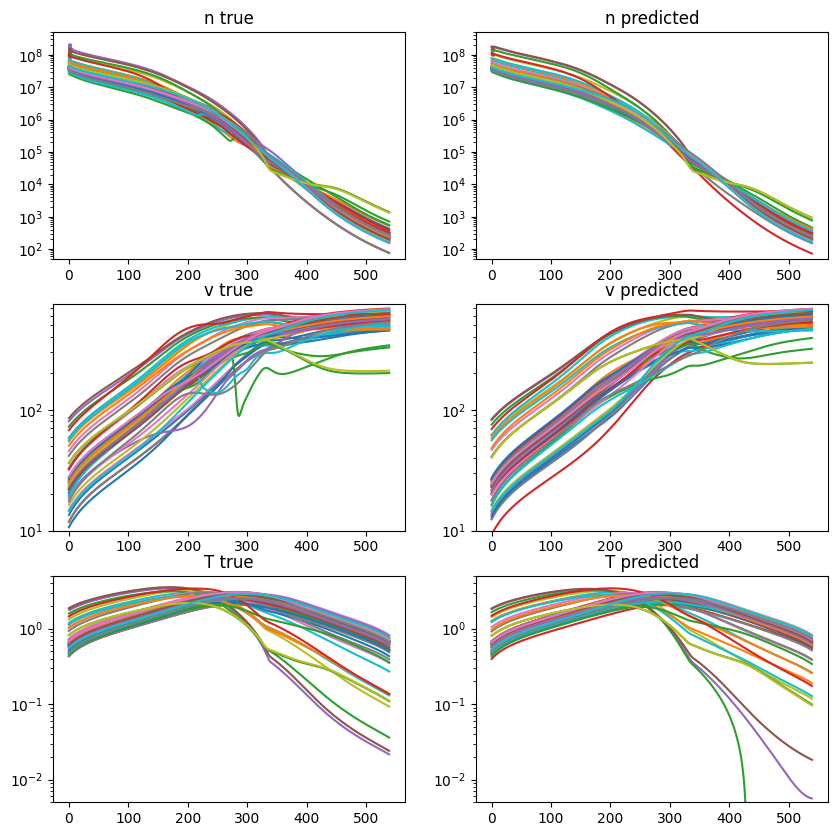

In [21]:
fig, axs = plt.subplots(3, 2, figsize=(10, 10))

output_names = ['n', 'v', 'T']
lims = [[50, 500000000], [10, 750], [0.005, 5]]

for i in range(3):
    axs[i, 0].plot(y_test_[:, i, :].T)
    axs[i, 0].set_yscale('log')
    axs[i, 0].set_ylim(lims[i])
    axs[i, 1].plot(y_pred[:, i, :].T)
    axs[i, 1].set_yscale('log')
    axs[i, 1].set_ylim(lims[i])
    
    axs[i, 0].set_title(f'{output_names[i]} true')
    axs[i, 1].set_title(f'{output_names[i]} predicted')
plt.show()


In [37]:
# loss on test set
model.eval()
test_loss = 0
with torch.no_grad():
    for i, (x, y) in enumerate(test_loader):
        y_pred = model(x)
        # denormalize y_pred and y
        loss = criterion(y_pred, y)
        test_loss += loss.item()
    test_loss /= len(test_loader)
    print(f'Test loss: {test_loss}')

Test loss: 0.00033520416782042127


3 hidden layers

48 nodes

ReLU

dropout 0.2 em todas